# 🏋️ 텍스트 및 이미지 임베딩으로 실험해보기 🍎

**건강 & 피트니스** 임베딩 노트북에 오신 것을 환영합니다! 이 튜토리얼은 다음과 같이 진행합니다:

1. Azure AI 파운드리 프로젝트에 액세스하려면 `AIProjectClient`를 **초기화**하세요.
2. 재미있는 건강 테마 문구와 함께 `azure-ai-inference`를 사용하여 **텍스트 삽입하기**.*
3. `azure-ai-inference`를 사용하여 **이미지 삽입**(Cohere의 이미지 임베딩 모델을 사용하고 있습니다).
4. **건강 테마 이미지**(예시 코드)를 생성하여 표시합니다.
5. 추가 컨텍스트가 필요한 경우 **프롬프트 템플릿**을 사용하세요.

이제 건강한 아이디어로 즐거운 시간을 보내세요! 🍏

> **고지사항**: 이 노트는 교육 목적으로만 사용됩니다. 의학적 조언은 항상 전문가와 상의하세요.

<img src="./seq-diagrams/2-embeddings.png" width="30%"/>

## 1. 환경 설정

#### Prerequisites:
- Azure AI Foundry에 텍스트 임베딩 모델(**text-embedding-3-small**) 배포
- Azure AI Foundry에 이미지 임베딩 모델(**Cohere-embed-v3-english**)을 배포합니다.
#
라이브러리를 가져오고 환경 변수를 로드합니다:
- `PROJECT_CONNECTION_STRING`: 프로젝트 연결 문자열
- `TEXT_EMBEDDING_MODEL`: 텍스트 임베딩 모델 배포 이름
- `IMAGE_EMBEDDING_MODEL`: 이미지 임베딩 모델 배포 이름

라이브러리를 가져오고, 환경 변수를 로드하고, `AIProjectClient`를 생성합니다.

> #### 이 노트북을 시작하기 전에 [1-basic-chat-completion.ipynb](./1-basic-chat-completion.ipynb) 노트북을 완성하세요.
시작합시다! 🚀

In [ ]:
import os
from dotenv import load_dotenv
from pathlib import Path

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.inference.models import ImageEmbeddingInput

# Load environment variables
notebook_path = Path().absolute()
parent_dir = notebook_path.parent
load_dotenv(parent_dir / '.env')

# Retrieve from environment or fallback
PROJECT_CONNECTION_STRING = os.environ.get("PROJECT_CONNECTION_STRING", "<your-connection-string>")
TEXT_EMBEDDING_MODEL = os.environ.get("TEXT_EMBEDDING_MODEL", "text-embedding-3-small")
IMAGE_EMBEDDING_MODEL = os.environ.get("IMAGE_EMBEDDING_MODEL", "Cohere-embed-v3-english")

# Initialize project client
try:
    project_client = AIProjectClient.from_connection_string(
        credential=DefaultAzureCredential(),
        conn_str=PROJECT_CONNECTION_STRING,
    )
    print("🎉 Successfully created AIProjectClient")
except Exception as e:
    print("❌ Error creating AIProjectClient:", e)

## 2. 텍스트 임베딩

`AIProjectClient`에서 `get_embeddings_client()`를 호출하여 임베딩 클라이언트를 검색합니다. 그런 다음 건강을 주제로 한 재미있는 문구를 임베드합니다:

- "🍎 An apple a day keeps the doctor away"
- "🏋️ 15-minute HIIT workout routine"
- "🧘 Mindful breathing exercises"

출력된 문구는 semantic space에서 각 문구를 나타내는 숫자 벡터가 됩니다. 임베딩된 내용을 살펴봅시다!

In [ ]:
text_phrases = [
    "An apple a day keeps the doctor away 🍎",
    "Quick 15-minute HIIT workout routine 🏋️",
    "Mindful breathing exercises 🧘"
]

try:
    with project_client.inference.get_embeddings_client() as embed_client:
        response = embed_client.embed(
            model=TEXT_EMBEDDING_MODEL,
            input=text_phrases
        )

        for item in response.data:
            vec = item.embedding
            sample_str = f"[{vec[0]:.4f}, {vec[1]:.4f}, ..., {vec[-2]:.4f}, {vec[-1]:.4f}]"
            print(f"Sentence {item.index}: '{text_phrases[item.index]}':\n" \
                  f"  Embedding length={len(vec)}\n" \
                  f"  Sample: {sample_str}\n")
except Exception as e:
    print("❌ Error embedding text:", e)

## 3. 프롬프트 템플릿 예제 📝

임베딩에 초점을 맞추고 있지만, 사용자 메시지에 컨텍스트를 추가하는 방법은 다음과 같습니다. 사용자 텍스트를 임베드하고 싶지만 먼저 “You are HealthFitGPT, a fitness guidance model…”와 같은 시스템 프롬프트를 추가한다고 가정해 보겠습니다. 이러한 사소하게 프롬프트에 추가 정보를 넣으면, 임베딩을 위한 단계를 설정할 때 더 많은 컨텍스트를 주어 도움을 줄 수 있습니다.


In [ ]:
# A basic prompt template (system-style) we'll prepend to user text.
TEMPLATE_SYSTEM = (
    "You are HealthFitGPT, a fitness guidance model.\n"
    "Please focus on healthy advice and disclaim you're not a doctor.\n\n"
    "User message:"  # We'll append the user message after this.
)

def embed_with_template(user_text):
    """Embed user text with a system template in front."""
    content = TEMPLATE_SYSTEM + " " + user_text
    with project_client.inference.get_embeddings_client() as embed_client:
        rsp = embed_client.embed(
            model=TEXT_EMBEDDING_MODEL,
            input=[content]
        )
    return rsp.data[0].embedding

sample_user_text = "Can you suggest a quick home workout for busy moms?"
embedding_result = embed_with_template(sample_user_text)
print("Embedding length:", len(embedding_result))
print("First few dims:", embedding_result[:8])

## 4. 이미지 임베딩

이미지 임베딩에는 일반적으로 관리되는 컴퓨팅 리소스가 필요합니다. Azure AI Foundry는 의료 이미지에 특화된 모델(예: **MedImageInsight**)을 제공하지만, 이 예에서는 Cohere의 서버리스 이미지 임베딩 모델을 사용합니다.

여기서는 **`hand-xray.png`** 이미지를 사용하여 임베딩을 생성합니다. 이 이미지(손 엑스레이)는 건강을 주제로 한 이미지를 재미있게 표현한 이미지입니다!

In [ ]:
try:
    with project_client.inference.get_image_embeddings_client() as img_embed_client:
        # Construct input for the image embeddings call
        img_input = ImageEmbeddingInput.load(image_file="hand-xray.png", image_format="png")
        resp = img_embed_client.embed(
            model=IMAGE_EMBEDDING_MODEL,
            input=[img_input]
        )

        for item in resp.data:
            vec = item.embedding
            snippet = f"[{vec[0]:.4f}, {vec[1]:.4f}, ..., {vec[-2]:.4f}, {vec[-1]:.4f}]"
            print(f"Image index={item.index}, length={len(vec)}, sample={snippet}")
except Exception as e:
    print("❌ Error embedding image:", e)

## 5. 건강 관련 이미지 생성 🏃 (선택 사항)

> **주의**: 현재 `azure-ai-inference` SDK에서는 이미지 생성이 지원되지 않습니다. 아래 예제에서는 Azure OpenAI의 DALL-E 3 모델과 함께 `openai` SDK를 사용합니다. 이 섹션은 `azure-ai-inference` SDK에서 이미지 생성이 지원되면 업데이트될 예정입니다.

Azure OpenAI의 DALL-E 3 모델을 사용하여 건강 테마 이미지를 생성해 보겠습니다. 다음 요소가 필요합니다:
1. Azure OpenAI 리소스에 DALL-E-3 모델 배포
2. `openai` Python 패키지 설치(`pip install openai`)
3. 환경 변수에 Azure OpenAI 엔드포인트 및 API 키 설정

시나리오를 설명하는 간단한 프롬프트를 전달하고 생성된 이미지를 인라인으로 표시합니다.


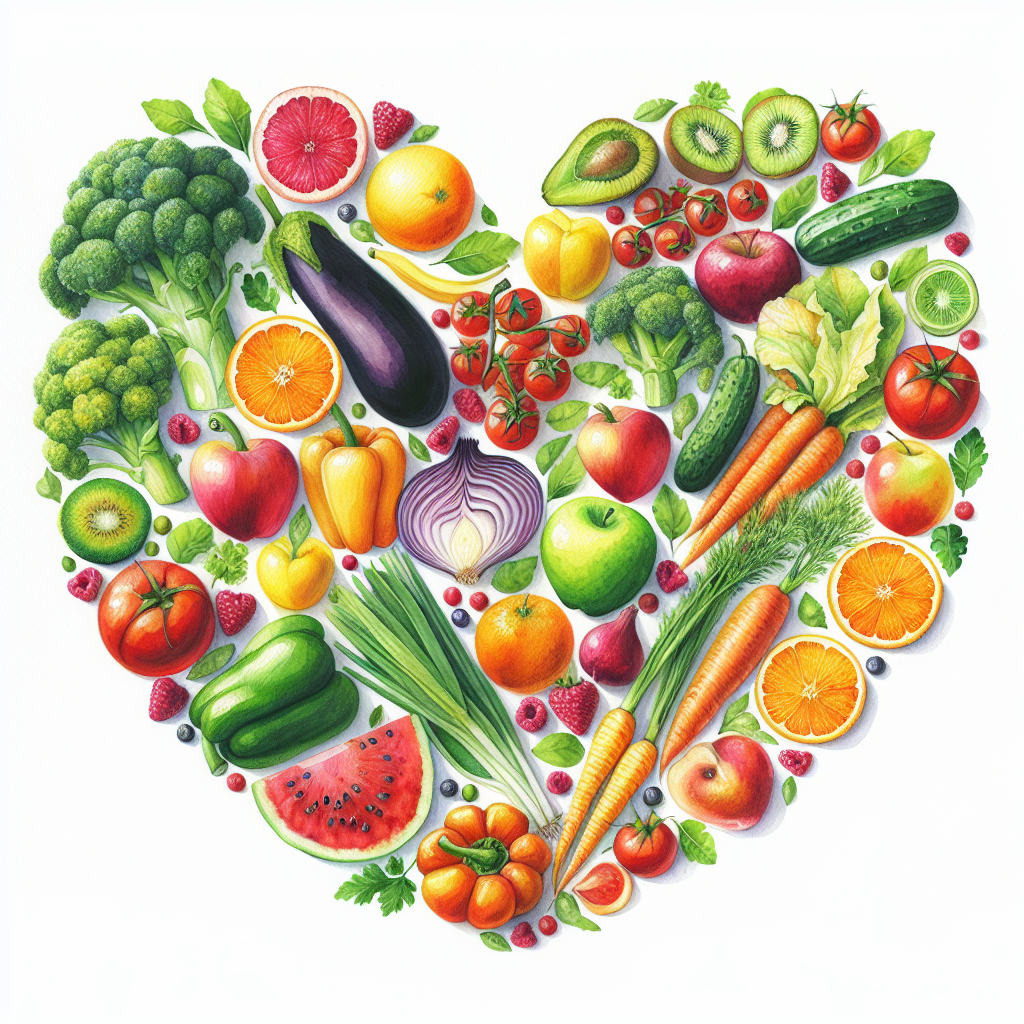

In [ ]:
import os
from openai import AzureOpenAI
import requests
from PIL import Image
from IPython.display import display

def generate_health_image(prompt="A simple cartoon of a happy person jogging outdoors"):
    try:
        # Initialize Azure OpenAI client
        client = AzureOpenAI(
            api_version="2024-02-01",
            api_key=os.getenv("AZURE_OPENAI_API_KEY", "YOUR-API-KEY"),
            azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT", "YOUR-AZURE-ENDPOINT")
        )
        
        # Generate image
        result = client.images.generate(
            model="dall-e-3", # your DALL-E 3 deployment name
            prompt=prompt,
            n=1
        )
        
        # Download and display image
        image_url = result.data[0].url
        image_data = requests.get(image_url).content
        
        # Save temporarily and display
        with open("temp_image.png", "wb") as f:
            f.write(image_data)
        img = Image.open("temp_image.png")
        display(img)
        
        # Clean up
        os.remove("temp_image.png")
        
    except Exception as e:
        print("❌ Error generating image:", e)

# Let's try generating a health image
generate_health_image("A watercolor painting of fresh fruits and vegetables arranged in a heart shape")

## 6. 마무리 및 다음 단계
🎉 여태까지 다음을 수행했습니다:
- `AIProjectClient`를 설정.
- *text-embedding-3-small*을 사용하여 **텍스트 임베딩** 을 가져옵니다..
- 건강 테마(손 엑스레이) 이미지에 *Cohere-embed-v3-english*를 사용하여 **이미지 임베딩**을 가져옵니다.
- 건강 테마 이미지(예시 코드)를 **생성**합니다.
- **프롬프트 템플릿**을 사용하여 임베딩에 시스템 컨텍스트를 추가합니다.

**다음에 수앵할 것**
- 임베딩을 평가하려면 `azure-ai-evaluation`을 살펴보세요.
- 엔드투엔드 원격 분석을 위해 `azure-core-tracing-opentelemetry`를 사용.
- 검색 파이프라인을 구축하여 임베딩의 유사성을 비교하세요.

즐겁게 태스트해보고, 건강에 관해서는 항상 전문가와 상담하세요!